In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import numpy as np
import scipy.stats as sst
import matplotlib.pyplot as plt
import os
import os.path as osp
from __future__ import print_function
from __future__ import division
import six
import cnv_util as util
reload(util)

<module 'cnv_util' from 'cnv_util.pyc'>

## Reading TSV files 

In [9]:
CWD = osp.join(osp.expanduser('~'), 'documents','grants_projects','roberto_projects', \
               'guillaume_huguet_CNV','27Oct2015')
filename = '20151027_Imagen_Annot_per_genes_MMAP_HI_TADA.txt'
fullfname = osp.join(CWD, filename)

In [10]:
arr_haplo = np.loadtxt(fullfname, dtype='str', comments=None, delimiter='\Tab', 
                 converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)

### some basic check for the columns of interest 

In [11]:
EXPECTED_LINES = 30752
expected_nb_values = EXPECTED_LINES - 1 
assert arr_haplo.shape[0] == EXPECTED_LINES
line0 = arr_haplo[0].split('\t')
print(line0)

haplo = 'Haplosuff_V3'
mmap = 'MMAP_signature'
per_gene = 'Per_Genes'
i_haplo = line0.index('Haplosuff_V3')
i_mmap = line0.index('MMAP_signature')
i_per_gene = line0.index('Per_Genes')
print(i_haplo, i_mmap, i_per_gene)

['IID_Projet', 'IID_Imagen_Merged_Pe_Qu', 'Chromosome', 'Loci_Start', 'Loci_Stop', 'Concat_CN=Type', 'Concat#SNP', 'Max_Score', 'All_Gene', 'Per_Genes', 'MMAP_signature', 'Haplosuff_V3', 'tadaFdrAscSscExomeSscAgpSmallDel']
11 10 9


In [12]:
# check that all lines have the same number of tab separated elements 
larr =  np.asarray([len(arr_haplo[i].split('\t')) for i in range(arr_haplo.shape[0])])
assert not (larr - larr[0]).any() # all element have the same value 

In [13]:
haplo = np.asarray([line.split('\t')[i_haplo] for line in arr_haplo[1:]])
mmap = np.asarray([line.split('\t')[i_mmap] for line in arr_haplo[1:]])
# print(np.unique(scores))

assert len(haplo) == expected_nb_values
assert len(mmap) == expected_nb_values

In [14]:
i_ND = np.where(haplo == 'ND')
a_ND = (haplo == 'ND')
print(a_ND.shape)
i_ND[0].shape
haplo.shape

(30751,)


(30751,)

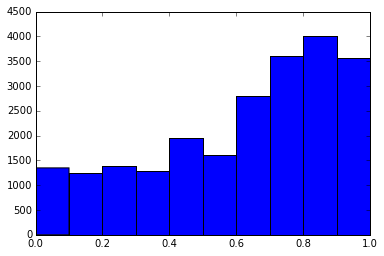

In [19]:

haplo_flt = [util.str2floats(h, comma2point=True)[0] for h in haplo[np.logical_not(a_ND)]]

_ = plt.hist(haplo_flt)

## From here : should be the same as CNV_Guillaume nb

In [20]:
a = [print(scores[i], tmp[i]) for i in range(1400,1410)]

15,534 15.534
18,383 18.383
15,186 15.186
15,857 15.857
27,779 27.779
26,9692 26.9692
154,984 154.984
15,245 15.245
34,422 34.422
18,911 18.911


In [21]:
#h = plt.hist(tmp, bins=100)
tmp = np.asarray(tmp)
print(tmp.shape)
assert tmp.shape[0] == EXPECTED_LINES - 1 
# h = plt.hist(tmp[tmp < sst.scoreatpercentile(tmp, 95)], bins=100)

(19541,)


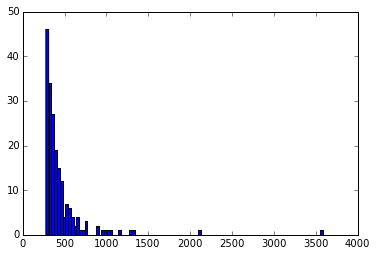

In [22]:
h = plt.hist(tmp[tmp > sst.scoreatpercentile(tmp, 99)], bins=100)

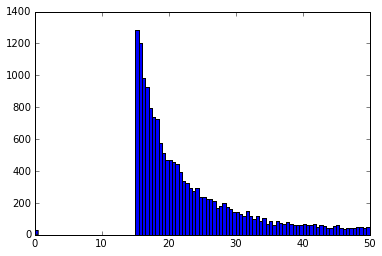

In [23]:
h = plt.hist(tmp[tmp < 50], bins=100)

In [24]:
print("# CNV with score == 0.: ", (tmp==0.).sum())
print("# CNV with score >=15 < 17.5 : ", np.logical_and(tmp >= 15., tmp < 17.5).sum())
tmp.max()

# CNV with score == 0.:  27
# CNV with score >=15 < 17.5 :  5202


3588.2600000000002

__QUESTION Guillaume:__

Y a t il seulement 27 CNV qui ont un score de "zero" ?

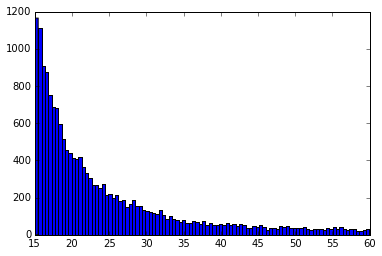

In [25]:
# if the score is zero, put it to maximum value : it means the CNV has a maximum score
clean_score = tmp
clean_score[tmp==0.] = tmp.max()
h = plt.hist(tmp[tmp < 60], bins=100)

### transforms the scores into P(cnv is real)

In [26]:
# from a copy paste of CNV_scores.xlsx

prob_cnv_vrai = \
"""15	20	80	25
17,5	24	76	25
20	36	64	25
22,5	44	56	25
25	83	17	60
27,5	77	23	44
30	95	5	60
"""

__ QUESTION Guillaume__ :

25 -> 27.5 : 83% true

27.5 -> 30 : 77% true

Y a t-il eu inversion ? ou s'agit il de bruit ? Reponse : il s'agit de bruit.

In [27]:
from collections import OrderedDict

p_cnv = OrderedDict({})
for line in prob_cnv_vrai.splitlines():
    line = line.split('\t')
    # print(line)
    p_cnv[float(line[0].replace(',','.'))] = float(line[1])/100.

    
# if model with linear piecewise
# p_cnv[45.] = 1.
# CORRECTION for a possible inversion - or simply "smooth" the curve !
# p_cnv[25], p_cnv[27.5] = p_cnv[27.5] , p_cnv[25]

print(p_cnv)

OrderedDict([(15.0, 0.2), (17.5, 0.24), (20.0, 0.36), (22.5, 0.44), (25.0, 0.83), (27.5, 0.77), (30.0, 0.95)])


__QUESTION Guillaume__

The last interval -- the one for which proba is 95.0 -- is [30.0, 32.5) ?

### Creating a function from score to proba from Guillaume's values

#### A piece wise linear function 

In [28]:
# Solution 1 : affine by pieces 
def aff(bi, bs, vbi, vbs, x0, y0):
    """
    returns the affine function
    """
    a = (vbs - vbi)/(bs - bi)
    b = y0  - a*x0
    
    def this_aff(x):
        return a*x + b
    
    return this_aff

def create_score2prob(p_cnv):

    # create a dict that has the affine function
    pf_cnv = OrderedDict({})
    kcnv = p_cnv.keys()

    for idx,k in enumerate(kcnv[:-1]):
        k1 = kcnv[idx+1]
        pf_cnv[k] = aff(k, k1, p_cnv[k], p_cnv[k1], k, p_cnv[k])
    
    # testing just this 
    def test_pf_cnv():
        assert pf_cnv[15](15) == .20
        assert abs(pf_cnv[15](17.5) - pf_cnv[17.5](17.5)) < np.finfo(float).eps
        assert abs(pf_cnv[17.5](20) - pf_cnv[20.](20.)) < np.finfo(float).eps
        assert abs(pf_cnv[20.](22.5) - pf_cnv[22.5](22.5)) < np.finfo(float).eps
        #assert pf_cnv[30](45) == 1.
        return True
    test_pf_cnv()
    
    # function linear piecewise:
    def sc2prob(sc):
        """
        returns the proba that cnv with score sc is a cnv; 
        """
        # 
        assert sc >= 15.
        kcnv = pf_cnv.keys()
        
        # if greater than the last key, returns 1.0
        if sc >= kcnv[-1]:
            return 1.0
        
        idx = 0
        while sc > kcnv[idx+1]: idx += 1
        
        return pf_cnv[kcnv[idx]](sc)
    
    return sc2prob
    

### TEST score2proba


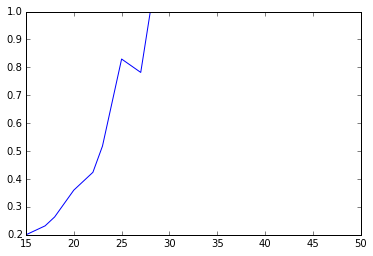

In [29]:
score2prob = create_score2prob(p_cnv)
scores = np.arange(15,50,1)
probs = [score2prob(sc) for sc in scores]
plt.plot(scores, probs)

#### Definition with a corrected regression line

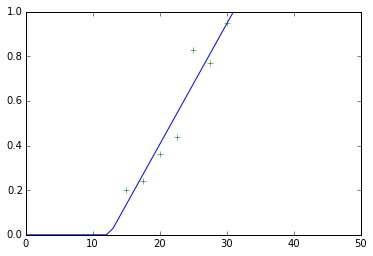

In [30]:
from scipy.interpolate import UnivariateSpline as spl

def create_score2prob_v2(p_cnv):

    kpcnv = p_cnv.keys()
    lin_funct = spl(kpcnv, p_cnv.values(), k=1)
    #x = np.arange(0,50,1)
    #plt.plot(x, lin_funct(x), '-', p_cnv.keys(), p_cnv.values(), '+')

    (x1, x2) = (kpcnv[0], kpcnv[-1])
    a = (lin_funct(x2) - lin_funct(x1))/(x2 - x1)
    b = lin_funct(x2) - a*x2
    x_where_y_is_1 = (1. - b)/a
    x_where_y_is_0 = (-b)/a

    
    def sc2prob(x):
        if x < x_where_y_is_0:
            return 0.
        elif x < x_where_y_is_1:
            return lin_funct(x)
        else:
            return 1.
    
    return sc2prob

x = np.arange(0,50,1)
score2prob = create_score2prob_v2(p_cnv)
plt.plot(x, [score2prob(_) for _ in x], '-', p_cnv.keys(), p_cnv.values(), '+')

In [31]:
p_scores = [score2prob(sc) for sc in clean_score]
assert len(p_scores) == EXPECTED_LINES -1 

## Finally, putting things together 

In [32]:
# re-loading 
CWD = osp.join(osp.expanduser('~'), 'documents','grants_projects','roberto_projects', \
               'guillaume_huguet_CNV','File_OK')
filename = 'Imagen_QC_CIA_MMAP_V2_Annotation.tsv'
fullfname = osp.join(CWD, filename)

# in numpy array
arr = np.loadtxt(fullfname, dtype='str', comments=None, delimiter='\Tab', 
                 converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)

line0 = arr[0].split('\t')
DANGER = 'Pvalue_MMAP_V2_sans_intron_and_Intergenic'
SCORE = 'SCORE'

i_DANGER = line0.index(DANGER)
i_SCORE = line0.index(SCORE)
i_START = line0.index('START')
i_STOP = line0.index('STOP')
i_5pGENE = line0.index("5'gene")
i_3pGENE = line0.index("3'gene")
i_5pDIST = line0.index("5'dist(kb)")
i_3pDIST = line0.index("3'dist(kb)")
#i_LOC = line0.index('Location')

for idx in range(len(line0)):
    print(line0[idx],': ', arr[1].split('\t')[idx])

IID_projet :  000067227272
IID_genotype :  67227272
SampleID :  67227272-660Wq
CHR de Merge_CIA_610_660_QC :  2
START :  41092148
STOP :  41109046
TYPE de Merge_CIA_610_660_QC :  1
SCORE :  22,895
ConcatSNP :  10
Gene :  0
Location :  Intergenic
#Genes :  0
#Exons :  0
5'gene :  SLC8A1
5'dist(kb) :  499,069
3'gene :  SGK493
3'dist(kb) :  1019.618
dups(DGV) :  13
dels(DGV) :  832
total_known_CNVs(DGV) :  845
num_papers(DGV) :  13
papers :  Altshuler et al. (2010), Conrad et al. (2005), Conrad et al. (2009), Itsara et al. (2009), Jakobsson et al. (2008), Matsuzaki et al. (2009), McCarroll et al. (2005), McCarroll et al. (2008), Park et al. (2010), Perry et al. (2008), Shaikh et al. (2009), Wang et al. (2007), de Smith et al. (2007)
hg18_DGV_1%_Mar2010.txt %overlap :  73%
hg18_Chromosome_band.txt :  2p22.1
hg18_segdups.txt %overlap :  0%
hg18_genome_features.txt :  0
hg18_genome_features.txt %overlap :  0%
Pvalue_MMAP_V2_sans_intron_and_Intergenic :  


In [33]:
# A function to create unique identifiers of subj, CNV, etc

def cnv_uiid(tsv_arr, columns_names, first_line=None):
    """
    columns_names: list of column names with which the uiid are constructed
    returns a list if given the full array, 
    returns a string if given only one line (and the first line)
    """
    
    chr2rm = ''.join([',', '.', ' ']) # others: ['!', '?', ...] ?
    
    if isinstance(tsv_arr, six.string_types) and (first_line != None):
        # assume we are given one line of the tsv array
        indexes = [first_line.split('\t').index(colname) for colname in columns_names]
        uiid = '_'.join([(tsv_arr.split('\t')[ind]).translate(None,chr2rm) for ind in indexes])
        
    else: 
        uiid = []
        indexes = [tsv_arr[0].split('\t').index(colname) for colname in columns_names]
        for line in tsv_arr[1:]:
            ll = line.split('\t')
            uiid.append('_'.join([ll[ind] for ind in indexes]))

    return uiid

In [35]:
print(line0)

['IID_projet', 'IID_genotype', 'SampleID', 'CHR de Merge_CIA_610_660_QC', 'START', 'STOP', 'TYPE de Merge_CIA_610_660_QC', 'SCORE', 'ConcatSNP', 'Gene', 'Location', '#Genes', '#Exons', "5'gene", "5'dist(kb)", "3'gene", "3'dist(kb)", 'dups(DGV)', 'dels(DGV)', 'total_known_CNVs(DGV)', 'num_papers(DGV)', 'papers', 'hg18_DGV_1%_Mar2010.txt %overlap', 'hg18_Chromosome_band.txt', 'hg18_segdups.txt %overlap', 'hg18_genome_features.txt', 'hg18_genome_features.txt %overlap', 'Pvalue_MMAP_V2_sans_intron_and_Intergenic']


In [38]:
#names_from = ['START', 'STOP', "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]

#---------- ligne uniques:
names_from = ['IID_projet', 'IID_genotype', "CHR de Merge_CIA_610_660_QC", 'START', 'STOP'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))

#---------- CNV uniques ? 
names_from = ["CHR de Merge_CIA_610_660_QC", 'START', 'STOP'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))

#---------- CNV uniques ? 
"""
names_from = ['START', 'STOP', "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))
"""

#---------- sujets uniques ? 
names_from = ['IID_projet'] # , 'IID_genotype'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))

dangers = np.asarray([line.split('\t')[i_DANGER] for line in arr[1:]])
scores = np.asarray([line.split('\t')[i_SCORE] for line in arr[1:]])

#danger_not_empty = dangers != ''
#print(danger_not_empty.sum())
#print(len(np.unique(cnv_name)))
#print(cnv_name[:10])

with names from:  ['IID_projet', 'IID_genotype', 'CHR de Merge_CIA_610_660_QC', 'START', 'STOP']
we have 19541 unique elements out of 19541 rows in the tsv
with names from:  ['CHR de Merge_CIA_610_660_QC', 'START', 'STOP']
we have 7337 unique elements out of 19541 rows in the tsv
with names from:  ['IID_projet']
we have 1712 unique elements out of 19541 rows in the tsv


### Create a dict of the cnv

In [39]:
#gene_name_set = set([line.split('\t')[i_3pGENE] for line in arr[1:]]) | \
#           set([line.split('\t')[i_5pGENE] for line in arr[1:]])
#print('len(gene_name_set): ', len(gene_name_set))

# this creates an dict where the keys are unique indentifiers of cnv, values 
# are (dangerosity, probability_cnv)

cnv = OrderedDict({})
names_from = ["CHR de Merge_CIA_610_660_QC", 'START', 'STOP']  #, "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]
blank_dgr = 0

for line in arr[1:]:
    lline = line.split('\t')
    dgr = lline[i_DANGER]
    scr  = lline[i_SCORE]
    cnv_iid = cnv_uiid(line, names_from, arr[0])
    
    if dgr != '':
        add_cnv = (danger_score(lline[i_DANGER], pH1_with_apriori),
                   score2prob(lline[i_SCORE]))
        if cnv_iid in cnv.keys():
            cnv[cnv_iid].append(add_cnv)
        else:
            cnv[cnv_iid] = [add_cnv]
    else:
        blank_dgr += 1


In [40]:
print(len(cnv), (blank_dgr))
print([k for k in cnv.keys()[:5]])

3374 12294
['10_134903403_134996704', '18_2578360_2611407', '17_17683629_17693534', '18_2576907_2611407', '17_17651995_17693534']


In [41]:
names_from = ["CHR de Merge_CIA_610_660_QC", 'START', 'STOP'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))
#print(cnv_names[:5])

# To be check : the 7337 unique cnv should reduce to 3374 when we remove those for which dgr == ''


with names from:  ['CHR de Merge_CIA_610_660_QC', 'START', 'STOP']
we have 7337 unique elements out of 19541 rows in the tsv


In [42]:
__kcnv = cnv.keys()
print(len(__kcnv))
for _ in __kcnv[3330:3350]:
    print(_,': ',cnv[_])

3374
1_995669_1011521 :  [(0.99999999999999312, 1.0)]
22_19339596_19429297 :  [(3.0, 1.0), (3.0, 1.0), (3.0, 1.0)]
22_19339596_19424781 :  [(3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0)]
22_19343347_19429297 :  [(3.0, 1.0)]
22_19345218_19424781 :  [(3.0, 1.0)]
22_18328337_18337023 :  [(1.0, 1.0), (1.0, 1.0), (1.0, 1.0)]
22_18330428_18337023 :  [(1.0, 1.0)]
22_18328337_18358558 :  [(2.0, 1.0)]
22_18336781_18400229 :  [(3.0, 1.0)]
2_110243431_110339819 :  [(1.9999998829812593, 1.0), (1.9999998829812593, 1.0), (1.9999998829812593, 1.0)]
21_14830513_14852044 :  [(0.99999999999989209, 1.0), (0.99999999999989209, 1.0), (0.99999999999989209, 1.0)]
11_127888014_127946707 :  [(0.99999999999999989, 1.0)]
7_73481452_73512817 :  [(0.99999999999998568, 1.0)]
22_48960865_49003996 :  [(2.9999999979009999, 1.0)]
22_48951780_48979320 :  [(1.9999999996940001, 1.0)]
22_48951780_49000551 :  [(3.999999997748000

In [43]:
#for k in cnv.keys():
#    if len(cnv[k]) > 1:
#        if len(set([cnv[k][i][0] for i in range(len(cnv[k]))])) > 1:
#            pass
#            # print(cnv[k])
#        #print([t[0] for t in cnv[k]])

### Create a dictionary of the subjects - 

In [44]:
#print(len(arr), line0)

In [45]:
cnv = OrderedDict({})
#names_from = ['START', 'STOP', "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]
names_from = ['IID_projet']

for line in arr[1:]:
    lline = line.split('\t')
    dgr = lline[i_DANGER]
    scr  = lline[i_SCORE]
    sub_iid = cnv_uiid(line, names_from, arr[0])
    
    if dgr != '':
        add_cnv = (danger_score(lline[i_DANGER], pH1_with_apriori),
                   score2prob(lline[i_SCORE]))
        if sub_iid in cnv.keys():
            cnv[sub_iid].append(add_cnv)
        else:
            cnv[sub_iid] = [add_cnv]

#### Histogram of the number of cnv used to compute dangerosity

1656
59


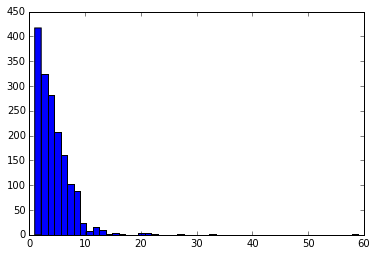

In [46]:
print(len(cnv))
nbcnv = [len(cnv[sb]) for sb in cnv]
hist = plt.hist(nbcnv, bins=50)
print(np.max(np.asarray(nbcnv)))

In [47]:
# definition of dangerosity from a list of cnv
def dangerosity(listofcnvs):
    """
    inputs: list tuples (danger_score, proba_cnv)
    returns: a dangerosity score 
    """
    last = -1 #slicing the last
    tmp = [np.asarray(t) for t in zip(*listofcnvs)]
    return tmp[0].dot(tmp[1])

# or: return np.asarray([dgr*prob for (dgr,prob) in listofcnvs]).cumsum()[last]


### Testing dangerosity

In [48]:
for k in range(1,30, 30):
    print(cnv[cnv.keys()[k]], ' yields ', dangerosity(cnv[cnv.keys()[k]]))
    
test_dangerosity_input = [[(1., .5), (1., .5), (1., .5), (1., .5)],
                          [(2., 1.)],
                          [(10000., 0.)]]
test_dangerosity_output = [2., 2., 0]

#print( [dangerosity(icnv) for icnv in test_dangerosity_input]) # == test_dangerosity_output
assert( [dangerosity(icnv) for icnv in test_dangerosity_input] == test_dangerosity_output)

[(0.99999942000033648, 1.0), (0.48377137638161954, 1.0), (0.49999999999999989, 1.0), (1.1666666666666665, 1.0)]  yields  3.15043746305


### Printing out results

In [49]:
outfile = 'dangerosity_cnv.txt'
fulloutfile = osp.join(CWD, outfile)

with open(fulloutfile, 'w') as outf:
    for sub in cnv:
        outf.write("\t".join([sub, str(dangerosity(cnv[sub]))]) + "\n")